$$ \Large \underline
{\textbf{Problema 1}}
$$

Determine los desplazamientos de los bordes libres y los esfuerzos en función de la posición para la
placa empotrada mostrada en la figura. Tome las dos particiones en elementos mostradas debajo y
compare los resultados. Asuma que E = 30 x 10e6
 psi y n = 0.30.

<center><img src="ImgProb01bG03.png"></center>

In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
import MEF as mef

In [2]:
gmsh.initialize()

In [3]:
gmsh.model.add('test_01')

In [4]:
L = 20  # in
lc = 1
h = 10  # in
v = 0.3  # coef Poisson
Ei = 30e6  # psi
t = 1  # in
T = 1000

In [5]:
p1 = gmsh.model.geo.addPoint(0,0,0,lc/10)
p2 = gmsh.model.geo.addPoint(L,0,0,lc)
p3 = gmsh.model.geo.addPoint(L,h,0,lc)
p4 = gmsh.model.geo.addPoint(0,h,0,lc/10)

In [6]:
l1 = gmsh.model.geo.addLine(p1,p2)
l2 = gmsh.model.geo.addLine(p2,p3)
l3 = gmsh.model.geo.addLine(p3,p4)
l4 = gmsh.model.geo.addLine(p4,p1)

In [7]:
C1 = gmsh.model.geo.addCurveLoop([l1,l2,l3,l4])

In [8]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

In [9]:
gmsh.model.geo.synchronize()

Ya están todos los elementos geométricos. 

In [10]:
Empotrado = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado,'Empotrado')

In [11]:
Traccionado = gmsh.model.addPhysicalGroup(1,[l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

In [12]:
Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie,'Superficie')

Realizo el mallado

In [13]:
gmsh.model.mesh.generate(2)  # Se genera el mallado con dimension 2. Mallado por Volronoi

In [14]:
gmsh.model.geo.synchronize()

In [15]:
gmsh.fltk.run()

In [16]:
NodeInfo = gmsh.model.mesh.get_nodes()

In [17]:
NumeroNodos = NodeInfo[0].shape[0]

In [18]:
MN = NodeInfo[1].reshape(NumeroNodos,3)

In [19]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

In [20]:
MC = ELEMENTS.reshape(ETAGS.shape[0],3)

In [21]:
gmsh.option.setNumber("Mesh.MshFileVersion",2.2)
gmsh.write('test.msh')

In [22]:
glxn = 2
dimension_elementos = 2

In [23]:
Ne, Nnxe = MC.shape
Nn = MN.shape[0]

In [24]:
E = np.zeros(Ne)
for e in range(Ne):
    E[e] = Ei

In [25]:
MC = MC - np.ones([Ne,Nnxe])  # resto 1 para acomodar a lenguaje python

In [26]:
K, Ke, D, B = mef.Kglobal_barra(MN, MC, E, glxn, dimension_elementos, v,t) 

Generalizo 's' para los nodos empotrados

In [27]:
nodos_empotrados, xyz_empotrados = gmsh.model.mesh.getNodesForPhysicalGroup(1, Empotrado)

In [28]:
s = []
for n in nodos_empotrados-1:
    s.append(glxn*n)
    s.append(glxn*n+1)
s = np.array(s).astype(int)

Us = np.zeros([s.shape[0]]).reshape([-1,1])

In [29]:
r = mef.vector_complemento(s, MN, glxn)

In [30]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])
Nlineastraccionadas = len(Ttraccionada[0])
MCtraccionadas = Ltraccionada[0].reshape(Nlineastraccionadas,2)-1

In [31]:
Fr = np.zeros_like(r)
for e in range(Nlineastraccionadas):
    nodo1 = MCtraccionadas[e,0].astype(int)
    nodo2 = MCtraccionadas[e,1].astype(int)
    Ltraccionado = abs(MN[nodo2,1]-MN[nodo1,1])
    Fr[np.where(r == nodo1*2)[0][0]] += T*Ltraccionado*t/2
    Fr[np.where(r == nodo2*2)[0][0]] += T*Ltraccionado*t/2
Fr = Fr.reshape([-1,1])

In [32]:
F, U = mef.solve(K, r, s, Us, Fr)

In [33]:
sig = {}
d = {}
for e in range(Ne):
    nodo = MC[e,:].astype(int)
    d[e] = np.array([U[nodo[0]*glxn],U[nodo[0]*glxn+1],
                     U[nodo[1]*glxn],U[nodo[1]*glxn+1],
                     U[nodo[2]*glxn],U[nodo[2]*glxn+1]]).reshape([-1,1])
    sig[e] = D[e].dot(B[e].dot(d[e]))

In [34]:
U2D = U.reshape(Nn,glxn)
U3D = np.append(U2D,np.zeros(U2D.shape[0]).reshape([-1,1]),1)

In [35]:
MNdef = MN + U3D*1e4

Text(0.5, 0, 'desplazamiento en x')

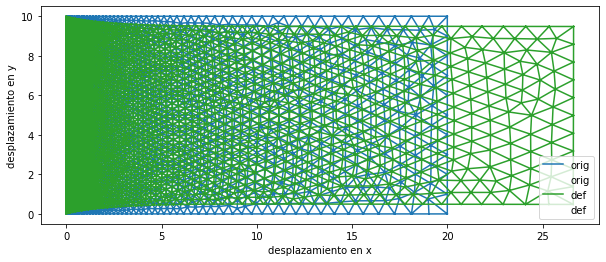

In [36]:
fig, ax = plt.subplots(figsize=(10,4))
plt.triplot(MN[:,0], MN[:,1], MC, label='orig')
plt.triplot(MNdef[:,0], MNdef[:,1], MC, label='def')
plt.legend()
plt.ylabel('desplazamiento en y')
plt.xlabel('desplazamiento en x')